# Tweet extraction

In this part we extract the tweets and form JSON files.

In [1]:
def custom_tweet( tweet_id, tweet_text, entities, label):
    new_d = dict()
    new_d["id"] = tweet_id
    new_d["text"] = tweet_text
    new_d["entities"] = entities
    new_d["label"] = label
    return new_d


In [2]:
import tweepy
import pandas as pd
import numpy as np
import json
import time
from tqdm.notebook import tqdm

In [3]:
with open('twitter_api.txt') as f:
     data = json.load(f)

In [4]:
# initialize tweepy
consumer_key = data["key"]
consumer_secret = data["secret-key"]

access_token = data["access-token"]
access_token_secret = data["access-token-secret"]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# reads df
df = pd.read_csv("data/filtered/racism_sexism_benevolent.csv", header = None)
df.head()

,0,1
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism


In [6]:
labels = dict(zip(df[0].to_numpy().astype(str), df[1]))

In [68]:
ids_to_request = df[0].to_numpy().tolist()

In [8]:
#test = custom_tweet(tweets[0].id_str, tweets[0].text, tweets[0].entities, "racist")
#test

In [9]:
#custom_tweets = dict()
#for tweet in tweets:
#    custom = custom_tweet(tweet.id_str, tweet.text, tweet.entities, labels[tweet.id_str])
#    custom_tweets[tweet.id_str] = custom

#custom_tweets

#with open('result.json', 'w') as fp:
#    json.dump(custom_tweets, fp)
#fp.close()

In [10]:
# read starting point
with open('init.txt', 'r') as fp:
    start = fp.read()
fp.close() 
start = int(start)
print(start)

1


In [11]:
for i in tqdm(range(start, int(len(ids_to_request)/100))):
    # get tweets
    tweets = api.statuses_lookup(ids_to_request[i*100:(i+1)*100])
    
    # get dict
    custom_tweets = dict()
    for tweet in tweets:
        custom = custom_tweet(tweet.id_str, tweet.text, tweet.entities, labels[tweet.id_str])
        custom_tweets[tweet.id_str] = custom
    
    # save them
    if len(tweets) > 0:
        f = open(f'data/filtered/racism_sexism_benevolent/{i:03d}.json', "w")
        json.dump(custom_tweets, f)
        f.close()
    
    # update init
    f = open('init.txt', 'w')
    f.write(str(i+1))
    f.close()
    
    

  0%|          | 0/138 [00:00<?, ?it/s]

In [12]:
int(len(ids_to_request)/100)

139

# Merging files

Merge files into one

In [69]:
import os
import json

In [70]:
all_tweets = dict()

for fn in os.listdir("data/filtered/racism_sexism_benevolent/"):
    f = open(f"data/filtered/racism_sexism_benevolent/{fn}", "r")
    data = json.load(f)
    all_tweets = {**all_tweets, **data}
    
# dump merged
f = open(f'data/filtered/racism_sexism_benevolent_extracted.json', "w")
json.dump(custom_tweets, f)
f.close()

# Distribution of the tweets

In [71]:
counter = [0] * 4   # racism, sexism, both, benevolent_sexism

In [72]:
for v in list(all_tweets.values()):
    label = v["label"]
    if label == "racism":
        counter[0] = counter[0] + 1
    elif label == "sexism":
        counter[1] = counter[1] + 1
    elif label == "both":
        counter[2] = counter[2] + 1
    elif label == "benevolent":
        counter[3] = counter[3] + 1

        
counter

[130, 3535, 18, 2386]

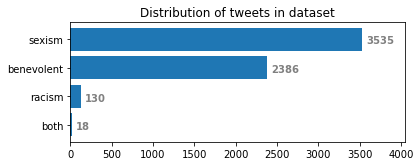

In [73]:
import matplotlib.pyplot as plt
import numpy as np

counter = np.array(counter)

idx = np.argsort(counter)

x = np.array(["racism", "sexism", "both", "benevolent"])[idx]
y = counter[idx]

fig, ax = plt.subplots(figsize = (6,2.2))
ax.barh(x,y)
ax.set_xlim([0, 4050])
for i, v in enumerate(y):
    ax.text(v + 50, i - 0.15, str(v), color="gray", fontweight='bold')
plt.title("Distribution of tweets in dataset")
plt.show()